<a href="https://colab.research.google.com/github/vinayshanbhag/math/blob/master/Expectation_Maximization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Expectation&ndash;Maximization

Expectation–maximization (EM) algorithm is an iterative method to find maximum likelihood estimates of parameters in statistical models, where the model depends on unobserved latent variables. For example, if we have data from *k* different gaussians, but we do not know which observation comes from which distribution. EM can be used to estimate the parameters of the underlying distributions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1-D Mixture Gaussian model

Let's say we have a set of points that come from 2 different gaussian distributions. 

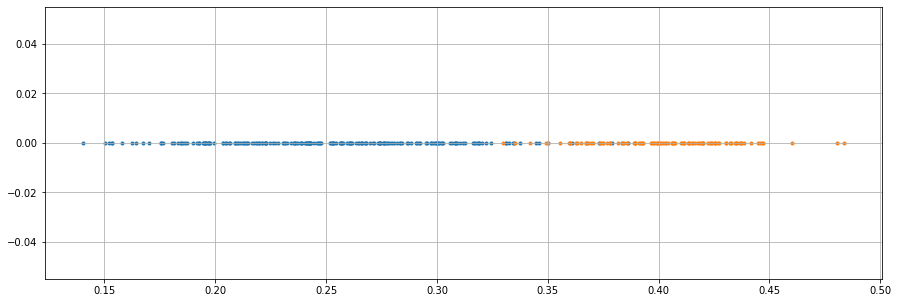

In [2]:
n1 = 200 # samples1
n2 = 100 # samples2
mu1, sig1, mu2, sig2 = 0.25,0.05,0.4,0.03
samples1 = np.random.normal(mu1, sig1, n1)
samples2 = np.random.normal(mu2, sig2, n2)
plt.figure(figsize=(15,5))
plt.grid();
plt.scatter(samples1,np.zeros(len(samples1)), marker='.'); 
plt.scatter(samples2,np.zeros(len(samples2)), marker='.');

Estimation is trivial if we know which point came from which source/distribution. For the blue points we can compute the mean and variance. Likewise for the orange points.

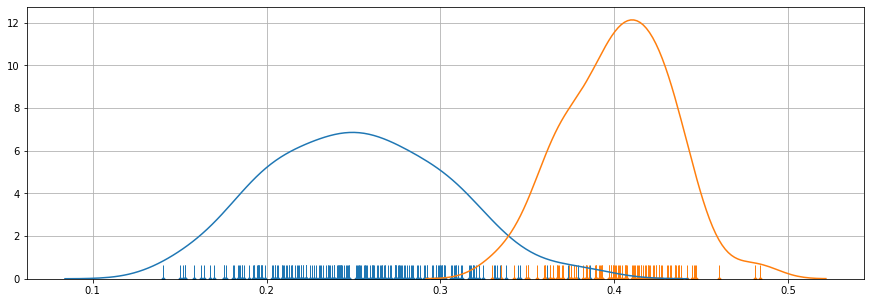

In [3]:
plt.figure(figsize=(15,5))
plt.grid()
plt.scatter(samples1,np.zeros(len(samples1)), marker='.'); 
plt.scatter(samples2,np.zeros(len(samples2)), marker='.');
sns.distplot(samples1, hist=False, rug=True)
sns.distplot(samples2, hist=False, rug=True); 

What if we don't know which point came from which source?

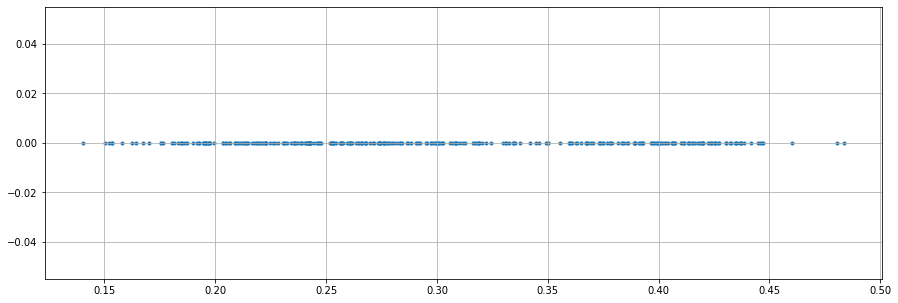

In [4]:
samples = np.append(samples1, samples2)
plt.figure(figsize=(15,5))
plt.grid()
plt.scatter(samples,np.zeros(len(samples)), marker='.'); 

We have a bunch of data points that came from *k* different Gaussian distributions. But we don't know which data point came from which source. We also do not know the parameters ($\mu,\sigma$) of those *k* Gaussian distributions.

This is the problem addressed by the Expectation&ndash;Maximization algorithm.

In [5]:
def plot(X,u1,s1,u2,s2,title):
  """ Plot mean and sigma at each step along with original data points."""
  plt.figure(figsize=(15,4))
  plt.title(title)
  plt.scatter(X,np.zeros(len(X)), marker='.') # plot original data points
  
  ax = sns.distplot(X, color='lightgray',hist=False, rug=True, 
                    kde_kws={"color": "lightgray", "lw": 1, "linestyle": ":"},
                    rug_kws={"color": sns.color_palette().as_hex()[0], "alpha":0.3, "linewidth": 1 }
                   ) # plot underlying distribution for reference (KDE plot)
  dist1_color = sns.color_palette().as_hex()[1]
  dist2_color = sns.color_palette().as_hex()[2]
  ymin, ymax = ax.get_ylim()
  # plot parameters for dist 1
  plt.vlines(u1,ymin,ymax,dist1_color,'-.')
  plt.text(u1,ymax,'$\mu_1$')
  plt.vlines(u1-s1,ymin,ymax,dist1_color,'dotted')
  plt.text(u1-s1,ymax*0.8,'$-\sigma_1$')
  plt.vlines(u1+s1,ymin,ymax,dist1_color,'dotted')
  plt.text(u1+s1,ymax*0.9,'$+\sigma_1$')
  # plot parameters for dist_2
  plt.vlines(u2,ymin,ymax,dist2_color,'-.')
  plt.text(u2,ymax,'$\mu_2$')
  plt.vlines(u2-s2,ymin,ymax,dist2_color,'dotted')
  plt.text(u2-s2,ymax*.8,'$-\sigma_2$')
  plt.vlines(u2+s2,ymin,ymax,dist2_color,'dotted')
  plt.text(u2+s2,ymax*.9,'$+\sigma_2$')
  
  plt.grid()
  
  plt.show()

## Expectation&ndash;Maximization Algorithm



* Start with 2 randomly placed Gaussians ($\mu_1, \sigma_1$) and ($\mu_2, \sigma_2$). Since we do not know how many samples came from each distribution, we will initialize the priors $P(dist_1)$ and $P(dist_2)$ to 0.5.
* Given these randomly placed Gaussians, for each point compute the probability that it belongs to each of these distributions
* Re-estimate ($\mu_1, \sigma_1$) and ($\mu_2, \sigma_2$) to fit the points assigned to them. Update the priors.
* Iterate until it converges

**Expectation step**

Compute probability of a data point given that it belongs to one distribution

$P(x_i|dist_1) = \frac{1}{\sqrt{2\pi\sigma_1^2}}e^{-\frac{(x_i-\mu_1)^2}{2\sigma_1^2}}$

Compute probability of a distribution given the data point

$P(dist_1|x_i) = \frac{P(x_i|dist_1)P(dist_1)}{P(x_i|dist_1)P(dist_1) + P(x_i|dist_2)P(dist_2)}$


$P(dist_2|x_i) = 1 - P(dist_1|x_i)$


**Maximization step**

Re-estimate $\mu$ and $\sigma$ to fit the points assigned to them

$\mu_1 = \frac{\displaystyle\sum_{i=1}^{n} P(dist_1|x_i).x_i}{\displaystyle\sum_{i=1}^{n} P(dist_1|x_i)}$

$\sigma_1 = \sqrt{\frac{\displaystyle\sum_{i=1}^{n} P(dist_1|x_i)(x_i-\mu_1)^2}{\displaystyle\sum_{i=1}^{n} P(dist_1|x_i)}}$

Update the priors-

$P(dist_1) = mean(P(dist_1|x_i))$ 

$P(dist_2) = 1-P(dist_1)$

Repeat until $\mu$ and $\sigma$ converge.

Following code performs these steps and plots the $\mu$ and $\sigma$ at each step.


In [6]:
X = samples
max_iter=100
iter_hist = []
u1,u2 = X.mean()-X.std(), X.mean()+X.std()#np.random.uniform(X.min(), X.max(), 2)
s1, s2 = u1*0.5, u2*0.5
p1,p2 = 0.5,0.5 # initialize priors of dist1 and dist2

iter_hist.append({"mean1":u1,"mean2":u2, "sigma1":s1,"sigma2":s2, "pdist1":p1,"pdist2":p2})
#plot(X, u1,s1, u2, s2, f"Iter:0\n$\mu_1={u1:0.4f};\sigma_1={s1:0.4f};\mu_2={u2:0.4f};\sigma_2={s2:0.4f};P(dist_1)={p1:0.2f};P(dist_2)={p2:0.2f};$")

for i in range(max_iter):
  #P(x|dist1)
  px_1 = (np.exp(-((X-u1)**2)/(2*(s1**2))))/np.sqrt(np.pi*2*(s1**2))
  #P(x|dist2)
  px_2 = (np.exp(-((X-u2)**2)/(2*(s2**2))))/np.sqrt(np.pi*2*(s2**2))
  
  #P(dist1|x)
  p1_x = (px_1*p1)/((px_1*p1) + (px_2*p2))
  #P(dist2|x)
  p2_x = (px_2*p2)/((px_1*p1) + (px_2*p2))
  
  #Update priors P(dist1) and P(dist2)
  p1 = np.mean(p1_x)
  p2 = np.mean(p2_x)

  #Compute new mean and sigma given 
  u1_ = np.sum(p1_x*X)/np.sum(p1_x)
  u2_ = np.sum(p2_x*X)/np.sum(p2_x)
  s1_ = np.sqrt(np.sum(p1_x*((X-u1)**2))/np.sum(p1_x))
  s2_ = np.sqrt(np.sum(p2_x*((X-u2)**2))/np.sum(p2_x))
  
  iter_hist.append({"mean1":u1,"mean2":u2, "sigma1":s1,"sigma2":s2, "pdist1":p1,"pdist2":p2})
  #plot(X, u1_,s1_, u2_, s2_, f"Iter:{i}\n$\mu_1={u1:0.4f};\sigma_1={s1:0.4f};\mu_2={u2:0.4f};\sigma_2={s2:0.4f};P(dist_1)={p1:0.2f};P(dist_2)={p2:0.2f};$")
  if np.allclose([u1,u2,s1,s2],[u1_,u2_,s1_,s2_], atol=1e-04):
    #print("Converged")
    break
  else:
    u1,u2,s1,s2=(u1_,u2_,s1_,s2_)


In [7]:
from matplotlib import animation, rc
from IPython.display import display, Math, HTML
rc('animation', html='html5')
c0 = sns.color_palette().as_hex()[0]
c1 = sns.color_palette().as_hex()[1]
c2 = sns.color_palette().as_hex()[2]

fig, ax = plt.subplots(figsize=(15,5))

lc = ax.vlines([],[],[])
text = ax.set_title([])

mean1_label = ax.text(0,0,'',fontsize=14,color=c1)
mean2_label = ax.text(0,0,'',fontsize=14,color=c2)
sigma1_label1 = ax.text(0,0,'',fontsize=12,color=c1)
sigma1_label2 = ax.text(0,0,'',fontsize=12,color=c1)
sigma2_label1 = ax.text(0,0,'',fontsize=12,color=c2)
sigma2_label2 = ax.text(0,0,'',fontsize=12,color=c2)

ymin,ymax=0,0

# initialization function: plot the background of each frame
def init():   
  plt.grid();
  sns.distplot(X, color='lightgray',hist=False, rug=True, 
               kde_kws={"color": "lightgray", "lw": 1, "linestyle": ":"},
               rug_kws={"color": c0, "alpha":0.3, "linewidth": 1 },
               ax=ax
              ) # plot underlying distribution for reference (KDE plot)
  global ymin, ymax
  ymin, ymax = ax.get_ylim()
  ax.set_xlim(( X.min(), X.max()))
  ax.set_ylim((ymin, ymax))
  plt.close()
  return (lc,)

# animation function. This is called sequentially
def animate(i):
    parms = iter_hist[i]
    m1 = parms["mean1"]
    m2 = parms["mean2"]
    s1 = parms["sigma1"]
    s2 = parms["sigma2"]
    p1 = parms["pdist1"]
    p2 = parms["pdist2"]

    lc.set_segments([[[m1,ymin],[m1,ymax]],
                     [[m2,ymin],[m2,ymax]],
                     [[m1-s1,ymin],[m1-s1,ymax]],
                     [[m1+s1,ymin],[m1+s1,ymax]],
                     [[m2-s2,ymin],[m2-s2,ymax]],
                     [[m2+s2,ymin],[m2+s2,ymax]],
                    ])
    lc.set_color([c1,c2,c1,c1,c2,c2])
    lc.set_linestyles(['-','-',':',':',':',':'])
    text.set_text(f"\nIteration #{i}\n$\mu_1={m1:0.2f}, \mu_2={m2:0.2f}, \sigma_1={s1:0.2f}, \sigma_2={s2:0.2f}, P(dist_1)={p1:0.2f}, P(dist_2)={p2:0.2f}$")
    
    mean1_label.set_text(r"$\mu_1$")
    mean1_label.set_x(m1);mean1_label.set_y(ymax*.89);
    mean2_label.set_text(r"$\mu_2$")
    mean2_label.set_x(m2);mean2_label.set_y(ymax*.9);
    
    sigma1_label1.set_text(r"$+\sigma_1$")
    sigma1_label1.set_x(m1+s1);sigma1_label1.set_y(ymax*.85);
    sigma1_label2.set_text(r"$-\sigma_1$")
    sigma1_label2.set_x(m1-s1);sigma1_label2.set_y(ymax*.85);
    
    sigma2_label1.set_text(r"$+\sigma_2$")
    sigma2_label1.set_x(m2+s2);sigma2_label1.set_y(ymax*.87);
    sigma2_label2.set_text(r"$-\sigma_2$")
    sigma2_label2.set_x(m2-s2);sigma2_label2.set_y(ymax*.87);

    return (lc,)


# call the animator. blit=True means only re-draw the parts that 
# have changed.
anim = animation.FuncAnimation(fig, animate, 
                               init_func=init,
                               frames=len(iter_hist), 
                               interval=300, 
                               blit=True, 
                               repeat=False
                              )

#writer = animation.PillowWriter()  
#anim.save('EM.gif', writer=writer)
anim

Compare the estimated Gaussian parameters to the original

In [8]:
display(Math(rf"Original \space Distribution: \mu_1={mu1:0.3f};\sigma_1={sig1:0.3f};\mu_2={mu2:0.3f};\sigma_2={sig2:0.3f};P(dist_1)={n1/(n1+n2):0.2f};P(dist_2)={n2/(n1+n2):0.2f}"))
display(Math(rf"Estimated \space Distribution: \mu_1={u1:0.3f};\sigma_1={s1:0.3f};\mu_2={u2:0.3f};\sigma_2={s2:0.3f};P(dist_1)={p1:0.2f};P(dist_2)={p2:0.2f}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>